In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
#first Camera calibration
def Camera_cailbration():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = os.listdir('camera_cal/')
    # Step through the list and search for chessboard corners
    for fname in images:
        image = cv2.imread("camera_cal/"+fname)
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)


            image2 = cv2.drawChessboardCorners(image, (9,6), corners , ret)
            cv2.imwrite("chessboard_drew/"+fname+"_drew_corners",image2)

    img = cv2.imread('test_images/straight_lines1.jpg')
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist


mtx, dist = Camera_cailbration()
pickle_dict={}
pickle_dict["mtx"] = mtx
pickle_dict["dist"] = dist


#save it for later use
with open('./calibrate_pickle.p', 'wb') as f:
    pickle.dump(pickle_dict, f)


In [10]:
with open("./calibrate_pickle.p", 'rb') as f:
    pickle.load(f)

mtx = pickle_dict['mtx']
dist = pickle_dict['dist']

testing_file = os.listdir("test_images/")
for i in testing_file:
    path = "test_images/"+i
    test=cv2.imread(path)
    test_undist = cv2.undistort(test, mtx, dist, None, mtx)
    cv2.imwrite("undistort_test_images/undistort_"+i, test_undist)


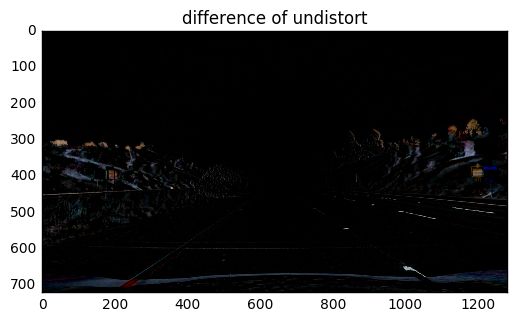

In [11]:
def show_different(img, img_undist):
    test = cv2.imread(img)
    test_un = cv2.imread(img_undist)
    diff = cv2.subtract(test, test_un)
    plt.imshow(diff)
    plt.title("difference of undistort")
    cv2.imwrite("./output_images/different_after_undistort.jpg",diff)
test_img = "./test_images/straight_lines1.jpg"
test_un_img = "./undistort_test_images/undistort_straight_lines1.jpg"
show_different(test_img,test_un_img)


In [12]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [13]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [14]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [15]:
def hls_threshold(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    
    return binary_output

In [16]:
def combining_threshold(img):
    
    gradx = abs_sobel_thresh(img, orient='x', thresh=(65, 255))
    mag_binary = mag_thresh(img, sobel_kernel=3, thresh=(65, 255))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.6, 1.5))
    hls_binary = hls_threshold(img, thresh=(170, 255))

    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1 | ((mag_binary == 1) & (dir_binary == 1))) | hls_binary == 1] = 1

    return combined, gradx, mag_binary, dir_binary, hls_binary 

In [17]:
test_img = "./undistort_test_images/undistort_test2.jpg"
# test_m = mpimg.imread(test_img)
test_m =cv2.imread(test_img)
threshold_test_m = combining_threshold(test_m)

plt.imsave("./output_images/test2_combined.jpg",threshold_test_m[0],cmap='gray')
plt.imsave("./output_images/test2_gradx.jpg",threshold_test_m[1],cmap='gray')
plt.imsave("./output_images/test2_mag_binary.jpg",threshold_test_m[2],cmap='gray')
plt.imsave("./output_images/test2_dir_binary.jpg",threshold_test_m[3],cmap='gray')
plt.imsave("./output_images/test2_hls_binary.jpg",threshold_test_m[4],cmap='gray')

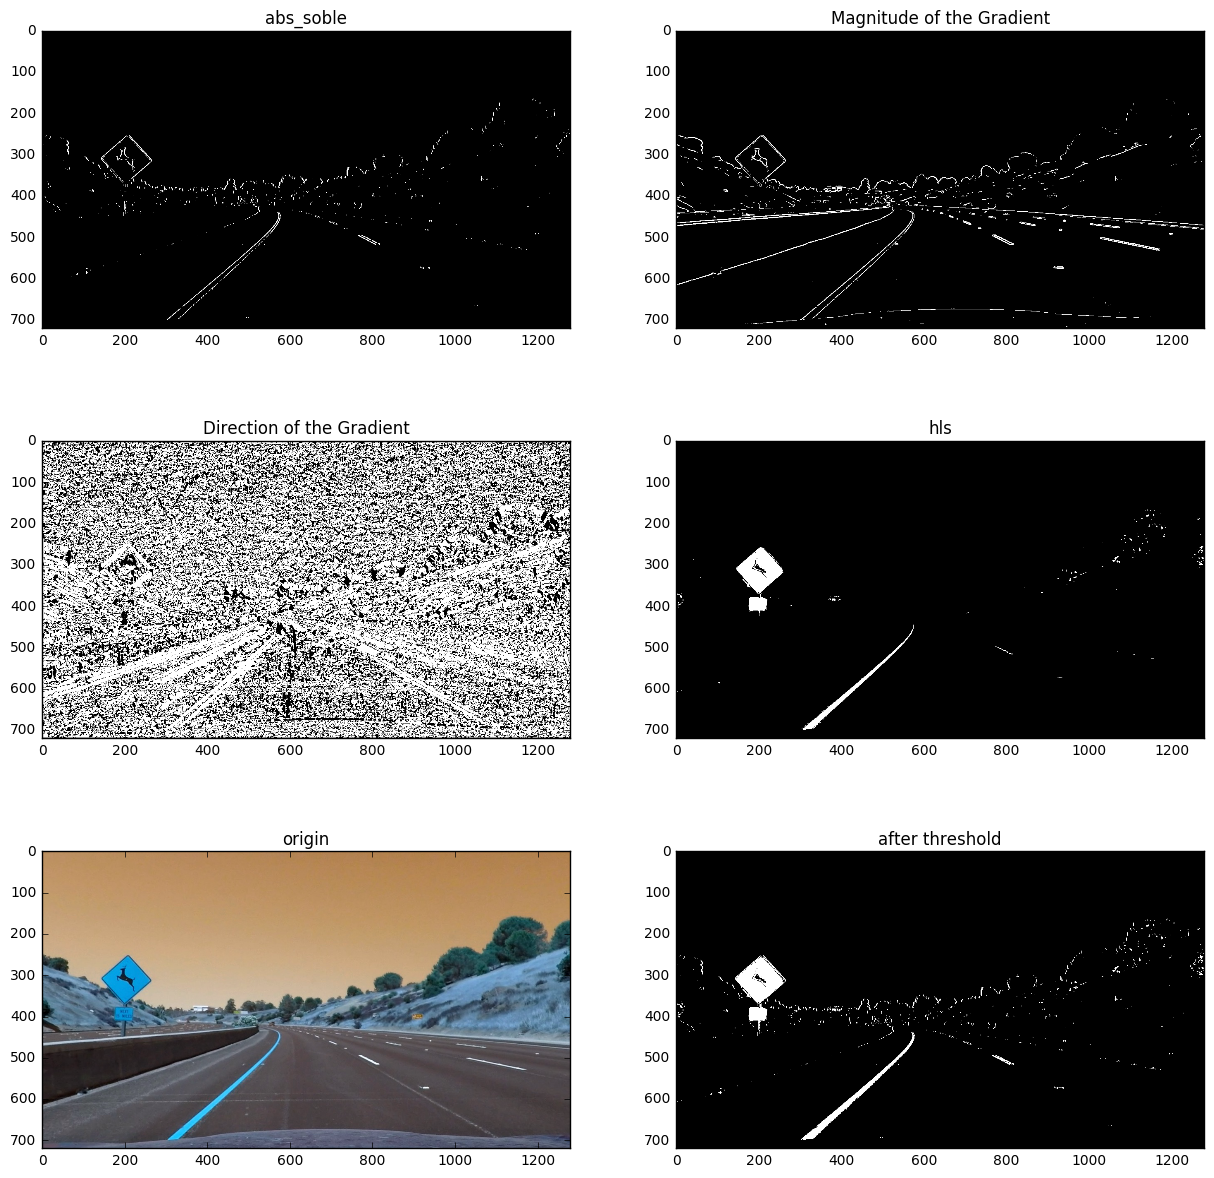

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(3, 2, 1)
plt.imshow(threshold_test_m[1], cmap='gray')
plt.title("abs_soble")
plt.subplot(3, 2, 2)
plt.imshow(threshold_test_m[2], cmap='gray')
plt.title("Magnitude of the Gradient")
plt.subplot(3, 2, 3)
plt.imshow(threshold_test_m[3], cmap='gray')
plt.title("Direction of the Gradient")
plt.subplot(3, 2, 4)
plt.imshow(threshold_test_m[4], cmap='gray')
plt.title("hls")
plt.subplot(3, 2, 5)
plt.imshow(test_m)
plt.title("origin")
plt.subplot(3, 2, 6)
plt.imshow(threshold_test_m[0], cmap='gray')
plt.title("after threshold")

plt.show()

In [19]:
def prespective_transform (img):
    img_size = (img.shape[1],img.shape[0])
#     print (img_size)
    src = np.float32([[200, 720],[1100, 720],[590, 450],[690, 450]])
    dst = np.float32([[200, 720],[1050, 720],[180, 0],[1070, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return Minv, warped

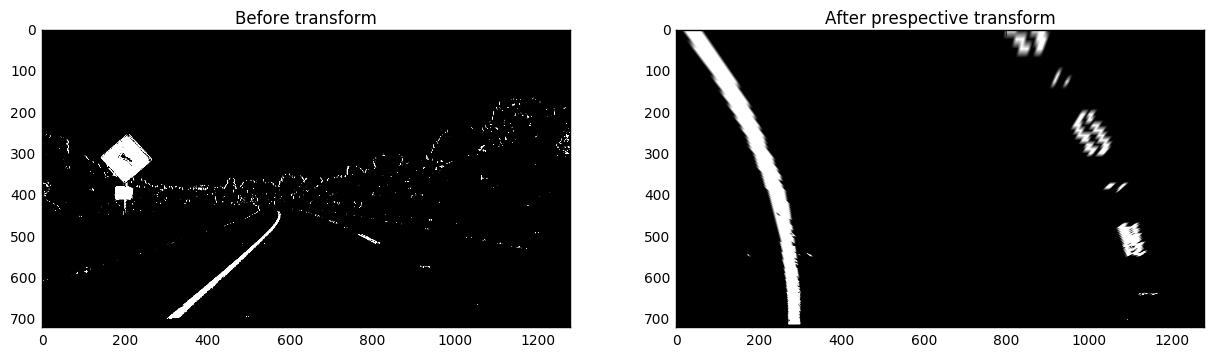

In [20]:
Minv ,warped_test_m = prespective_transform(threshold_test_m[0])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(threshold_test_m[0],cmap = "gray")
plt.title("Before transform")
plt.subplot(1,2,2)
plt.imshow(warped_test_m, cmap = "gray")
plt.title("After prespective transform")
plt.imsave("./output_images/test2_bird_view.jpg",warped_test_m, cmap='gray')


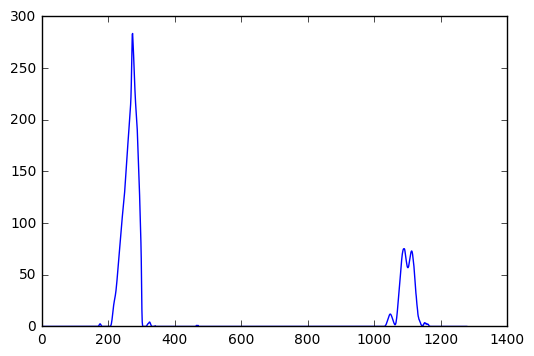

In [21]:
histogram = np.sum(warped_test_m[int(warped_test_m.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [22]:
def cal_curve(leftx, lefty, rightx, righty, ploty, image_size):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #calculate the position of the car 
    img_height = image_size[0] * ym_per_pix
    img_width = image_size[1] * xm_per_pix
    
    #finding the interception
    left_intercept = left_fit_cr[0] * img_height ** 2 + left_fit_cr[1] * img_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * img_height ** 2 + right_fit_cr[1] * img_height + right_fit_cr[2]
    
    #center between the left line and the right line
    center = (left_intercept + right_intercept) / 2.0
    
    #how much off between car and the center of the image
    position = (center - img_width / 2.0)
    
    return left_curverad, right_curverad, position

In [23]:
def find_lane(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
#     out_img = np.stack([binary_warped, binary_warped, binary_warped],axis = 2)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    out_img = np.dstack((warp_zero, warp_zero, warp_zero))
#     print(out_img.shape)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_c, right_c, position = cal_curve(leftx, lefty, rightx, righty, ploty, (binary_warped.shape[0],binary_warped.shape[1]))
#     return left_fitx, right_fitx, ploty, left_fit, right_fit, out_img
    return left_fitx, right_fitx, ploty, left_fit, right_fit, out_img, left_c, right_c, position


In [24]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def adv_find_lane(binary_warped, left_fit, right_fit):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_c, right_c, position = cal_curve(leftx, lefty, rightx, righty, ploty, (binary_warped.shape[0],binary_warped.shape[1]))

    return left_fitx, right_fitx, ploty,left_fit, right_fit, left_c, right_c, position

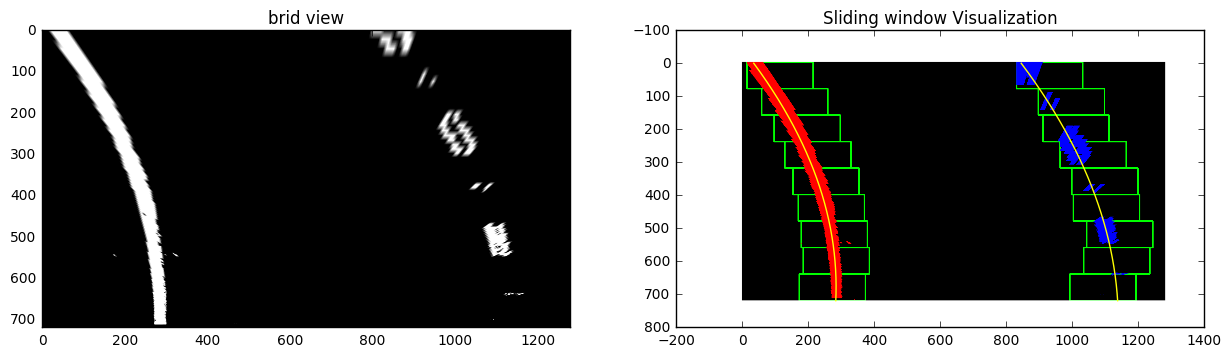

In [25]:
left_fitx, right_fitx, ploty, left_fit, right_fit, out_img,_,_,_ =find_lane(warped_test_m)
plt.imsave("./output_images/find_lane.jpg", out_img)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(warped_test_m,cmap = "gray")
plt.title("brid view")
plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Sliding window Visualization")





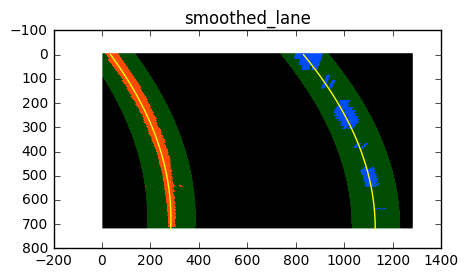

In [26]:
# And you're done! But let's visualize the result here as well
# Create an image to draw on and an image to show the selection window
# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
left_fitx, right_fitx, ploty, left_fit, right_fit, out_img,_,_,_ =find_lane(warped_test_m)

nonzero = warped_test_m.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100

left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped_test_m.shape[0]-1, warped_test_m.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]




warp_zero = np.zeros_like(warped_test_m).astype(np.uint8)
out_img = np.dstack((warp_zero, warp_zero, warp_zero))
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

fig = plt.figure(figsize=(5,5))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("smoothed_lane")
# fig.savefig("./output_images/smooth_lane.jpg")

In [27]:
def draw_lane_line(undist_img, warp_img, Minv, left_fitx, right_fitx, ploty,left_c, right_c, position):
    
    #create empty image to draw on
    warp_zero = np.zeros_like(warp_img).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp =np.zeros_like(undist_img)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.5, 0)
    
    curvature_info = "Curvature: Left = " + str(np.round(left_c, 2)) + ", Right = " + str(np.round(right_c, 2)) 
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(result, curvature_info, (25, 50), font, 1, (0,255, 255), 2)
    position_info = "Position from center = {:.2f} m".format(position) 
    font = cv2.FONT_HERSHEY_TRIPLEX    
    cv2.putText(result, position_info, (25, 100), font, 1, (0,255, 255), 2)

    return result


True

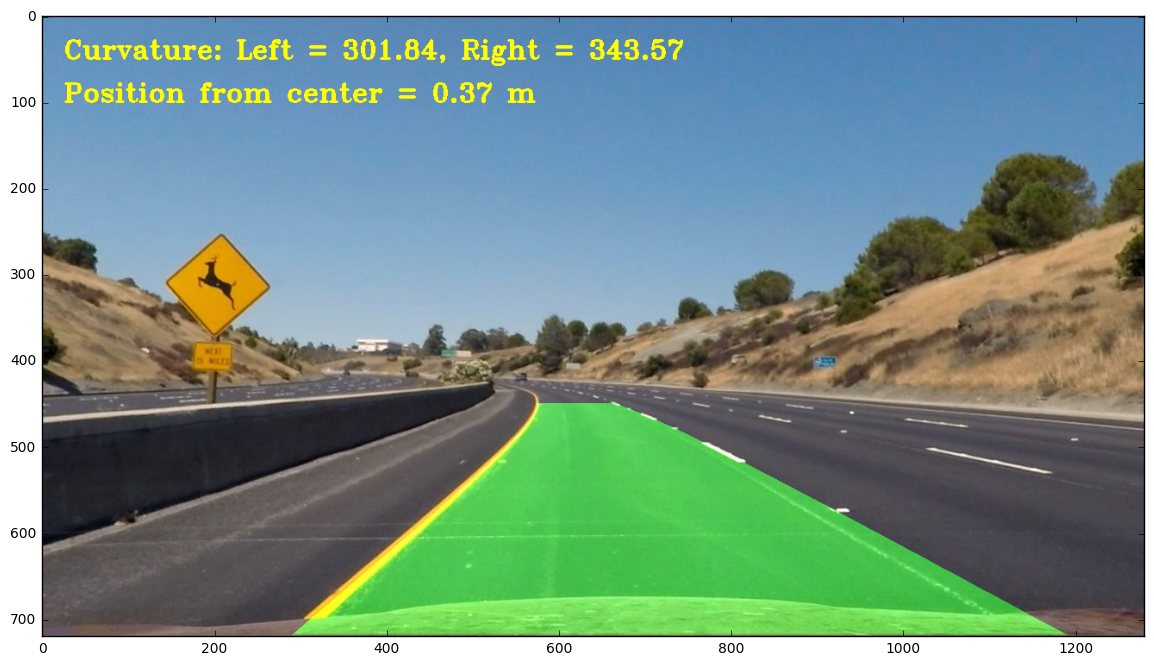

In [28]:
test_img = "./output_images/undistort_test2.jpg"
undist_img =cv2.imread(test_img)

Minv ,warped_test_m = prespective_transform(threshold_test_m[0])
left_fitx, right_fitx, ploty, left_fit, right_fit, out_img,left_c, right_c, position =find_lane(warped_test_m)


result = draw_lane_line(undist_img,warped_test_m , Minv, left_fitx, right_fitx, ploty, left_c, right_c, position)
plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
cv2.imwrite("./output_images/result.jpg", result)

In [68]:
global curvature
global y_eval
global xm_per_pix
global ym_per_pix
global midx
global left_fit
global right_fit
curvature = 0
y_eval = 700
xm_per_pix = 3./72.
ym_per_pix = 3.7/660.
midx = 640
def update_fits(left_fit, right_fit,curvature):
    mse_tolerance = 0.01 
    left_error = ((left_fit[0] - left_fit[0]) ** 2).mean(axis=None)      
    right_error = ((right_fit[0] - right_fit[0]) ** 2).mean(axis=None)        
    if left_error < mse_tolerance:
        left_fit = 0.75 * left_fit + 0.25 * left_fit   
    if right_error < mse_tolerance:
        right_fit = 0.75 * right_fit + 0.25 * right_fit
    curvature=update_curvature(right_fit,curvature)
    return left_fit, right_fit, curvature
def update_curvature(right_fit,curvature = 0):
        """Update radius of curvature
        """
        y1 = (2*right_fit[0]*y_eval + right_fit[1])*xm_per_pix/ym_per_pix
        y2 = 2*right_fit[0]*xm_per_pix/(ym_per_pix**2)
        curvature1 = ((1 + y1**2)**(1.5))/np.absolute(y2)
        if first_frame:
            return curvature1
        if np.absolute(curvature - curvature1) < 500:
            curvature1 = 0.75*curvature + 0.25*(((1 + y1*y1)**(1.5))/np.absolute(y2)) 
        return curvature1
def video_pipeline(images):
    global first_frame
    global curvature
    global y_eval
    global xm_per_pix
    global ym_per_pix
    global midx
    global left_fit
    global right_fit
    first = True
    left= []
    right=[]
    mtx, dist = Camera_cailbration()
    undist_img = cv2.undistort(images, mtx, dist, None, mtx)
    combined, _, _, _, _ = combining_threshold(undist_img)
    Minv, warped = prespective_transform(combined)
    if not first_frame:
        print('first')
        left_fitx, right_fitx, ploty, left_fit, right_fit, out_img, left_c, right_c, position =find_lane(warped)

        first_frame = True
    else:
        print('sec')
        left_fit, right_fit,curvature = update_fits(left_fit, right_fit,curvature)
        left_fitx, right_fitx, ploty,left_fit, right_fit, left_c, right_c, position  =adv_find_lane(warped, left_fit, right_fit)
    lane_lines_img = draw_lane_line(undist_img,warped_test_m , Minv, left_fitx, right_fitx, ploty, left_c, right_c, position)
    return lane_lines_img



In [ ]:
from pathlib import Path
import os
my_file = Path('temp_fit.npz')
video_output = "output_images/project_video_output1.mp4"
clip1 = VideoFileClip("project_udacity.mp4")
# if my_file.is_file(): 
#     os.remove('temp_fit.npz')
global first_frame
first_frame = False
clip1_output = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

first
[MoviePy] >>>> Building video output_images/project_video_output1.mp4
[MoviePy] Writing video output_images/project_video_output1.mp4










  0%|          | 0/91 [00:00<?, ?it/s]







  1%|          | 1/91 [00:14<21:53, 14.60s/it]

sec










  2%|▏         | 2/91 [00:29<21:59, 14.82s/it]

sec










  3%|▎         | 3/91 [00:44<21:42, 14.80s/it]

sec










  4%|▍         | 4/91 [01:00<21:54, 15.11s/it]

sec










  5%|▌         | 5/91 [01:17<22:35, 15.77s/it]

sec










  7%|▋         | 6/91 [01:33<22:27, 15.85s/it]

sec


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))